In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import os, shutil
import open3d as o3d
from stereovision.calibration import StereoCalibration, StereoCalibrator
from stereovision.point_cloud import PointCloud
from stereovision.exceptions import ChessboardNotFoundError

In [44]:
def removeFolderContent(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [53]:
def match_color_balance(reference_img: np.ndarray, target_img: np.ndarray):
    ref_channels = cv2.split(reference_img)
    target_channels = cv2.split(target_img)
    ref_means = [np.mean(ch) for ch in ref_channels]
    target_means = [np.mean(ch) for ch in target_channels]

    balanced_channels = []
    for ref_mean, target_mean, channel in zip(ref_means, target_means, target_channels):
        scale = ref_mean / target_mean if target_mean != 0 else 1
        balanced = np.clip(channel * scale, 0, 255).astype(np.uint8)
        balanced_channels.append(balanced)

    return cv2.merge(balanced_channels)

In [55]:
def match_lighting(reference_img: np.ndarray, target_img: np.ndarray):
    ref_gray = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
    target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

    ref_mean, ref_std = np.mean(ref_gray), np.std(ref_gray)
    target_mean, target_std = np.mean(target_gray), np.std(target_gray)

    adjusted = target_img.astype(np.float32)
    adjusted = adjusted - target_mean + ref_mean

    if target_std != 0:
        adjusted *= (ref_std / target_std)

    return np.clip(adjusted, 0, 255).astype(np.uint8)

In [105]:
cam1 = cv2.VideoCapture(0)
cam2 = cv2.VideoCapture(1)
if not cam1.isOpened() or not cam2.isOpened():
    print("Error: Could not open one or both cameras")
    exit()

Test Cameras

In [81]:
while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        cv2.imshow('Left Camera', frame1)
        frame2 = match_lighting(frame1, frame2)
        frame2 = match_color_balance(frame1, frame2)
        cv2.imshow('Right Camera', frame2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()

In [104]:
cam1.release()
cam2.release()

## Calibration

In [58]:
CHESSBOARD_SIZE = (8,6)

### Capture Chessboard

In [115]:
CALIBRATION_PATH = "calibration/"
removeFolderContent(CALIBRATION_PATH)
os.makedirs(f"{CALIBRATION_PATH}/left")
os.makedirs(f"{CALIBRATION_PATH}/right")

In [116]:
img_count = 0
while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        frame2 = match_lighting(frame1, frame2)
        frame2 = match_color_balance(frame1, frame2)
        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        # Save the images when 's' is pressed
        key = cv2.waitKey(1)
        if key & 0xFF == ord('s'):
            img_count += 1
            cv2.imwrite(f'{CALIBRATION_PATH}/left/{img_count}.jpg', frame1)
            cv2.imwrite(f'{CALIBRATION_PATH}/right/{img_count}.jpg', frame2)
            print(f"Saved image pair {img_count}")
        # Break on 'q' key press
        if key & 0xFF == ord('q'):
            break
    else:
        print("Failed to capture image pair")

cv2.destroyAllWindows()

Saved image pair 1
Saved image pair 2
Saved image pair 3
Saved image pair 4
Saved image pair 5
Saved image pair 6
Saved image pair 7
Saved image pair 8
Saved image pair 9
Saved image pair 10
Saved image pair 11
Saved image pair 12
Saved image pair 13
Saved image pair 14
Saved image pair 15
Saved image pair 16
Saved image pair 17
Saved image pair 18
Saved image pair 19
Saved image pair 20
Saved image pair 21
Saved image pair 22
Saved image pair 23


### Calibrate

Start cycle
Importing pair: 1
Importing pair: 2
Importing pair: 3
Importing pair: 4
Importing pair: 5
Importing pair: 6
Importing pair: 7
Importing pair: 8
Importing pair: 9
Importing pair: 10
Importing pair: 11
Importing pair: 12
Importing pair: 13
Importing pair: 14
Importing pair: 15
Importing pair: 16
Importing pair: 17
Importing pair: 18
Importing pair: 19
Importing pair: 20
Importing pair: 21
Importing pair: 22
Importing pair: 23
Cycle Complete!
Starting calibration... It can take several minutes!
Calibration complete!


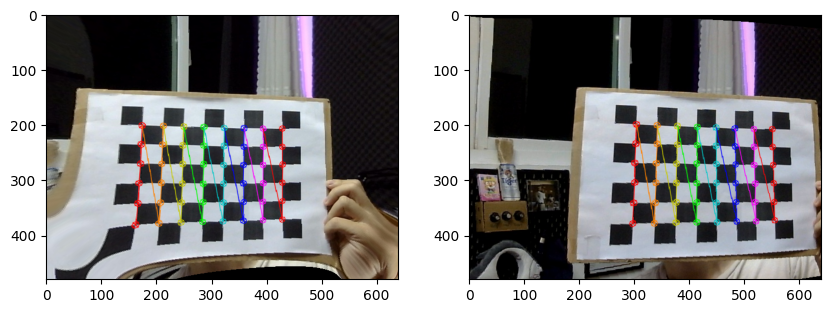

In [117]:
rows = 6
columns = 8
square_size = 2.5

frame_height = int(cam1.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(cam1.get(cv2.CAP_PROP_FRAME_WIDTH))
calibrator = StereoCalibrator(rows, columns, square_size, (frame_width, frame_height))
print('Start cycle')

img_count = len([name for name in os.listdir('calibration/left') if os.path.isfile(os.path.join('calibration/left', name))])
for index in range(1, img_count + 1):
    print(f'Importing pair: {index}')
    leftName = f'calibration/left/{index}.jpg'
    rightName = f'calibration/right/{index}.jpg'
    if os.path.isfile(leftName) and os.path.isfile(rightName):
        #reading the images in Color
        imgLeft = cv2.imread(leftName, 1)
        imgRight = cv2.imread(rightName, 1)

        #Ensuring both left and right images have the same dimensions
        (H, W, C) = imgLeft.shape

        imgRight = cv2.resize(imgRight, (W, H))

        # Calibrating the camera (getting the corners and drawing them)
        try:
            calibrator._get_corners(imgLeft)
            calibrator._get_corners(imgRight)
        except ChessboardNotFoundError as error:
            print(error)
            print("Pair No " + str(index) + " ignored")
        else:
            calibrator.add_corners((imgLeft, imgRight), show_results=True)

    else:
        print ("Pair not found")
        continue


print('Cycle Complete!')

print('Starting calibration... It can take several minutes!')
calibration = calibrator.calibrate_cameras()
calibration.export('calib_result')
print('Calibration complete!')

# Lets rectify and show last pair after  calibration
calibration = StereoCalibration(input_folder='calib_result')
rectified_pair = calibration.rectify((imgLeft, imgRight))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(rectified_pair[0][:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(rectified_pair[1][:, :, ::-1])

## Depth Map

In [228]:
def setup_stereo_matcher(is_left: bool = True) -> cv2.StereoSGBM:
    params = {
        'minDisparity': 0 if is_left else -144,
        'numDisparities': 144,
        'blockSize': 5,
        'P1': 50 * 5**3,
        'P2': 100 * 5**3,
        'disp12MaxDiff': 4,
        'uniquenessRatio': 5,
        'speckleWindowSize': 200,
        'speckleRange': 3,
        'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
    }
    return cv2.StereoSGBM_create(**params)

### Capture video

In [229]:
VIDEO_PATH = "video"
removeFolderContent(VIDEO_PATH)

In [230]:
frame_width = int(cam1.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam1.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 20.0

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out1 = cv2.VideoWriter(f'{VIDEO_PATH}/left.avi', fourcc, fps, (frame_width, frame_height))
out2 = cv2.VideoWriter(f'{VIDEO_PATH}/right.avi', fourcc, fps, (frame_width, frame_height))

while True:
    ret1, frame1 = cam1.read()
    ret2, frame2 = cam2.read()

    if ret1 and ret2:
        out1.write(frame1)
        frame2 = match_lighting(frame1, frame2)
        frame2 = match_color_balance(frame1, frame2)
        out2.write(frame2)

        cv2.imshow('Left Camera', frame1)
        cv2.imshow('Right Camera', frame2)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("Failed to grab frames.")
        break

out1.release()
out2.release()
cv2.destroyAllWindows()

### Compute Death

In [231]:
focal_length = 1350
baseline = 0.085

In [232]:
video_left = cv2.VideoCapture("video/left.avi")
video_right = cv2.VideoCapture("video/right.avi")
export_left_frame = None
while True:
    left_grabbed, left_frame = video_left.read()
    right_grabbed, right_frame = video_right.read()

    if not left_grabbed or not right_grabbed:
        break

    left_gray_frame = cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
    right_gray_frame = cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)

    calibration = StereoCalibration(input_folder='calib_result')
    rectified_pair = calibration.rectify((left_gray_frame, right_gray_frame))

    stereo_left = setup_stereo_matcher(True)
    stereo_right = setup_stereo_matcher(False)

    disp_left = stereo_left.compute(rectified_pair[0], rectified_pair[1])
    disp_right = stereo_right.compute(rectified_pair[1], rectified_pair[0])

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(stereo_left)
    wls_filter.setLambda(3000)
    wls_filter.setSigmaColor(1.8)
    filtered_disp = wls_filter.filter(disp_left, left_frame, None, disp_right)

    depth = np.zeros_like(filtered_disp, dtype=np.float32)
    valid_mask = filtered_disp > 0
    depth[valid_mask] = (focal_length * baseline) / filtered_disp[valid_mask] * 10

    disp_visual = cv2.normalize(filtered_disp, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    cv2.imshow("left",rectified_pair[0])
    cv2.imshow("right",rectified_pair[1])
    cv2.imshow("disp", filtered_disp)

    time.sleep(10/1000)

    k = cv2.waitKey(1) & 0xFF
    if k == ord('q'):
        export_left_frame = left_frame
        break

    else:
        continue

video_left.release()
video_right.release()
cv2.destroyAllWindows()

In [233]:
h, w = depth.shape
fx = focal_length
fy = focal_length
cx = left_frame.shape[1] // 2
cy = left_frame.shape[0] // 2

x, y = np.meshgrid(np.arange(w), np.arange(h))
mask = depth > 0
x3 = (x[mask] - cx) * depth[mask] / fx
y3 = (y[mask] - cy) * depth[mask] / fy
z3 = depth[mask]

points = np.stack((x3, y3, z3), axis=-1)
colors = left_frame[mask].astype(np.float32) / 255.0

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])

AttributeError: 'NoneType' object has no attribute 'shape'

## Distance detection

In [217]:
distance = 0
point_clicked = None
def onMouse(event, x, y, flag, disparity_normalized):
    if event == cv2.EVENT_LBUTTONDOWN:
        distance = disparity_normalized[y][x]
        print("Distance in meters {}".format(distance))
        point_clicked = (x, y)

In [235]:
cv2.namedWindow("DepthMap")
clicked_point = None

while True:
    left_grabbed, left_frame = cam1.read()
    right_grabbed, right_frame = cam2.read()

    if left_grabbed and right_grabbed:
        left_gray_frame = cv2.cvtColor(left_frame, cv2.COLOR_BGR2GRAY)
        right_gray_frame = cv2.cvtColor(right_frame, cv2.COLOR_BGR2GRAY)

        calibration = StereoCalibration(input_folder='calib_result')
        rectified_pair = calibration.rectify((left_gray_frame, right_gray_frame))

        stereo_left = setup_stereo_matcher(True)
        stereo_right = setup_stereo_matcher(False)

        disp_left = stereo_left.compute(rectified_pair[0], rectified_pair[1])
        disp_right = stereo_right.compute(rectified_pair[1], rectified_pair[0])

        wls_filter = cv2.ximgproc.createDisparityWLSFilter(stereo_left)
        wls_filter.setLambda(4700)
        wls_filter.setSigmaColor(1.2)
        filtered_disp = wls_filter.filter(disp_left, left_frame, None, disp_right)

        depth = np.zeros_like(filtered_disp, dtype=np.float32)
        valid_mask = filtered_disp > 0
        depth[valid_mask] = (focal_length * baseline) / filtered_disp[valid_mask] * 10

        depth_display = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
        depth_display = np.uint8(depth_display)
        depth_color = cv2.applyColorMap(depth_display, cv2.COLORMAP_JET)

        # Set mouse callback on the "DepthMap" window
        cv2.setMouseCallback("DepthMap", onMouse, depth)

        if clicked_point is not None:
            x, y = clicked_point
            if distance > 0:
                text = f"{distance:.2f} m"
                cv2.circle(depth_color, (x, y), 5, (255, 255, 255), -1)
                cv2.putText(depth_color, text, (x + 10, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

                # Show warning or "cool" based on that depth
                if distance < 0.5:
                    cv2.putText(depth_color, "Too close, get away!", (30, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
                else:
                    cv2.putText(depth_color, "Cool", (30, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
            else:
                cv2.putText(depth_color, "Invalid point", (30, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)

        # Display the depth map and frames side-by-side
        cv2.imshow("DepthMap",depth_color)
        cv2.imshow("Frames", np.hstack((left_frame, right_frame)))

        k = cv2.waitKey(1) & 0xFF
        if k == ord('q'):
            break
        else:
            continue

cv2.destroyAllWindows()

Distance in meters 1.0517873764038086
Distance in meters 0.8793103694915771
Distance in meters 0.6842576265335083
